In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
from cort.core.corpora import Corpus
import os
from docopt import docopt
import sys
import re
from collections import defaultdict
from utils import map_values
import codecs


def read_dataset(inp_dir):
    mentions, tokens, names = defaultdict(list), defaultdict(list), defaultdict(list)
    for fname in os.listdir(inp_dir):
        if fname.endswith('_gold_conll'):
            genre = infer_genre(fname)
            path = os.path.join(inp_dir, fname)
            try:
                with codecs.open(path, 'r', 'utf-8') as f:
                    corpus = Corpus.from_file('', f)
            except KeyError:
                # https://github.com/dmcc/PyStanfordDependencies/issues/24
                sys.stderr.write("Ignored due to parsing error: %s\n" %path)
            for doc in corpus:
                if not doc.annotated_mentions:
                    sys.stderr.write("Document doesn't contain any mention: %s\n" %doc.identifier)
                else:
                    my_mentions, my_tokens, my_names = read_document(doc)
                    mentions[genre].extend(my_mentions)
                    tokens[genre].extend(my_tokens)
                    names[genre].extend(my_names)
    mentions['all'] = [n for list_ in mentions.values() for n in list_]
    tokens['all'] = [n for list_ in tokens.values() for n in list_]
    names['all'] = [n for list_ in names.values() for n in list_]
    return mentions, tokens, names


def infer_genre(fname):
    return re.match(r'(\w{2})_', fname).group(1)


def read_document(doc):
    mentions = [m for m in doc.annotated_mentions]
    tokens = [doc.tokens[i]
              for m in mentions
              for i in range(m.span.begin, m.span.end+1)]
    names = [' '.join(doc.tokens[i] 
                       for i in range(m.span.begin, m.span.end+1)
                       if doc.pos[i] in ['NNP', 'NNPS'])
              for m in mentions]
    names = [n for n in names if n != '']
    return mentions, tokens, names

In [3]:
inp_dir = '../data/conll-2012-flat'
_, train_tokens, train_names = read_dataset(os.path.join(inp_dir, 'train'))

Document doesn't contain any mention: (bn/voa/00/voa_0043); part 000
Document doesn't contain any mention: (nw/wsj/10/wsj_1088); part 000
Document doesn't contain any mention: (nw/wsj/13/wsj_1384); part 000
Document doesn't contain any mention: (bc/cnn/00/cnn_0001); part 009
Document doesn't contain any mention: (nw/xinhua/02/chtb_0205); part 000
Ignored due to parsing error: ../data/conll-2012-flat/train/tc_ch_0005.v4_gold_conll
Document doesn't contain any mention: (bn/voa/00/voa_0017); part 000
Document doesn't contain any mention: (bn/abc/00/abc_0024); part 000
Document doesn't contain any mention: (bn/abc/00/abc_0054); part 000
Document doesn't contain any mention: (nw/xinhua/01/chtb_0175); part 000
Document doesn't contain any mention: (nw/wsj/13/wsj_1342); part 000
Document doesn't contain any mention: (nw/wsj/14/wsj_1408); part 000
Document doesn't contain any mention: (bn/pri/00/pri_0097); part 000
Document doesn't contain any mention: (bn/voa/00/voa_0065); part 000
Document d

In [4]:
test_mentions, test_tokens, test_names = read_dataset(os.path.join(inp_dir, 'test-key'))

Document doesn't contain any mention: (bc/cnn/00/cnn_0008); part 008
Document doesn't contain any mention: (nw/wsj/23/wsj_2390); part 000


In [5]:
num_test_mentions = map_values(test_mentions, len)

In [6]:
num_test_mentions

{'pt': 3417,
 'bn': 2943,
 'nw': 4374,
 'mz': 1347,
 'bc': 3985,
 'wb': 2167,
 'tc': 1531,
 'all': 19764}

In [7]:
import numpy as np
import pandas as pd

def measure_coverage(train, test, num_test_mentions, type_):
    data = []
    unique_train = map_values(train, set)
    unique_test = map_values(test, set)
    for genre in train:
        num_covered = sum(1 for n in test[genre] if n in unique_train[genre])
        num_unique_covered = len(unique_test.get(genre, set())
                                      .intersection(unique_train[genre]))
        data.append({
            'type': type_,
            'genre': genre,
            'num_train': len(train[genre]),
            'num_test': len(test[genre]),
            'num_unique_train': len(unique_train[genre]),
            'num_unique_test': len(unique_test.get(genre, set())),
            'num_covered': num_covered,
            'num_unique_covered': num_unique_covered,
            'proportion_covered': np.float64(num_covered) / len(test[genre]),
            'proportion_unique_covered': np.float64(num_unique_covered) / len(unique_test[genre]),
            'num_test_mentions': num_test_mentions[genre]
        })
    return data

In [8]:
data = (measure_coverage(train_tokens, test_tokens, num_test_mentions, 'tokens') +
        measure_coverage(train_names, test_names, num_test_mentions, 'names'))
df = pd.DataFrame(data)

In [9]:
df

,genre,num_covered,num_test,num_test_mentions,num_train,num_unique_covered,num_unique_test,num_unique_train,proportion_covered,proportion_unique_covered,type
0,pt,5931,6088,3417,72138,582,665,2233,0.974212,0.875188,tokens
1,nw,12298,13708,4374,108694,2015,2773,11195,0.897140,0.726650,tokens
2,bn,6549,7264,2943,57748,1183,1630,6391,0.901569,0.725767,tokens
3,mz,2680,3302,1347,33878,553,890,4453,0.811629,0.621348,tokens
4,bc,7142,8257,3985,34897,749,1241,3716,0.864963,0.603546,tokens
5,tc,1784,2067,1531,15298,223,380,1669,0.863087,0.586842,tokens
6,wb,3606,4341,2167,29759,520,940,4502,0.830684,0.553191,tokens
7,all,42424,45027,19764,352412,4409,5764,19845,0.942190,0.764920,tokens
8,pt,746,807,3417,9635,71,101,642,0.924411,0.702970,names
9,nw,983,2041,4374,15780,214,821,5232,0.481627,0.260658,names


In [10]:
readable_genres = {
    'all': 'all genres',
    'bc': 'broadcast conv.',
    'bn': 'broadcast news',
    'mz': 'magazine',
    'nw': 'newswire',
    'pt': 'bible',
    'tc': 'telephone',
    'wb': 'websites'
}

In [11]:
df['readable_genres'] = df['genre'].apply(lambda g: readable_genres[g])
df2 = (df[['proportion_covered', 'readable_genres', 'num_test_mentions', 'type']]
       .rename(columns={'proportion_covered': 'coverage', 'readable_genres': 'genre'})
       .sort_values('num_test_mentions', ascending=False))

In [12]:
df2

,coverage,genre,num_test_mentions,type
7,0.942190,all genres,19764,tokens
15,0.609585,all genres,19764,names
1,0.897140,newswire,4374,tokens
9,0.481627,newswire,4374,names
4,0.864963,broadcast conv.,3985,tokens
12,0.516785,broadcast conv.,3985,names
0,0.974212,bible,3417,tokens
8,0.924411,bible,3417,names
2,0.901569,broadcast news,2943,tokens
10,0.649642,broadcast news,2943,names


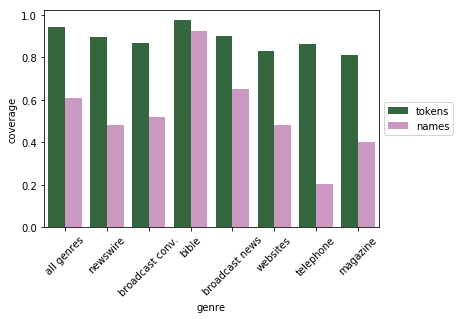

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('cubehelix', n_colors=2)
plt.xticks(rotation=45)
ax = sns.barplot(x='genre', y='coverage', hue='type', data=df2)
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
ax.get_figure().savefig('../output/genre_name_coverage.pdf')

## Explore the relationship of coverage and performance

In [15]:
import pandas as pd

In [16]:
# see notebooks/stats_conll_2012.ipynb
performance_data = [
    ('bc', 55, 64.02),
    ('tc', 61.96, 71.36),
    ('wb', 57.64, 66.11),
    ('bn', 56.37, 66.78),
    ('nw', 54.62, 65.05),
    ('mz', 57.69, 75.19),
    ('pt', 66.65, 78.02)
]
performance_data_df = pd.DataFrame(performance_data, columns=['genre', 'sieve_avg_score', 'deep_coref_avg_score'])

In [17]:
df['proportion_covered_pct'] = df['proportion_covered'] * 100
genre_info = df[['genre', 'readable_genres', 'num_test_mentions']].drop_duplicates()
performance_with_genre_info = pd.merge(genre_info, performance_data_df, on='genre')
all_data = pd.concat([
    df[['proportion_covered_pct', 'readable_genres', 'num_test_mentions', 'type']]
       .rename(columns={'proportion_covered_pct': 'value', 'type': 'variable'}),
    performance_with_genre_info.melt(id_vars=['readable_genres', 'num_test_mentions'], 
                                     value_vars=['sieve_avg_score', 'deep_coref_avg_score'])
]).sort_values('num_test_mentions', ascending=False)

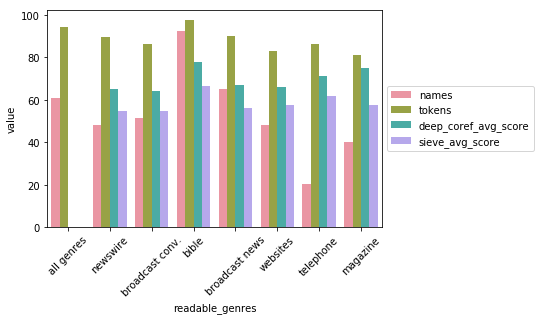

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('cubehelix', n_colors=2)
plt.xticks(rotation=45)
ax = sns.barplot(x='readable_genres', y='value', hue='variable', data=all_data)
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [19]:
pivoted = all_data.pivot(index='readable_genres', values='value', columns='variable')

/Users/cumeo/Library/Python/3.6/lib/python/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


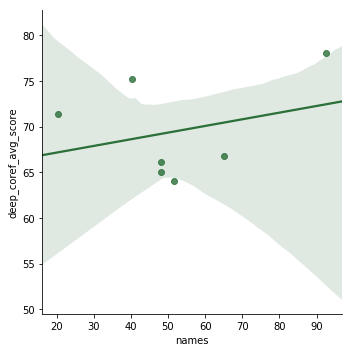

In [20]:
sns.lmplot('names', 'deep_coref_avg_score', data=pivoted)

/Users/cumeo/Library/Python/3.6/lib/python/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


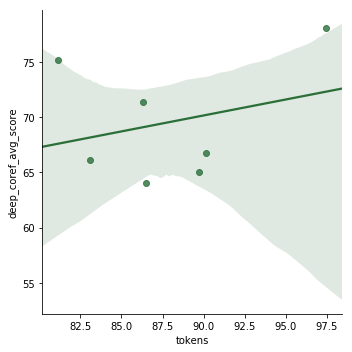

In [21]:
sns.lmplot('tokens', 'deep_coref_avg_score', data=pivoted)

In [22]:
pivoted.corr()

variable,deep_coref_avg_score,names,sieve_avg_score,tokens
variable,,,,
deep_coref_avg_score,1.000000,0.298097,0.827959,0.284556
names,0.298097,1.000000,0.385668,0.761997
sieve_avg_score,0.827959,0.385668,1.000000,0.539883
tokens,0.284556,0.761997,0.539883,1.000000
